## Analysis of ReAct and LLM-DP Alfworld data

In [79]:
import json
import glob

output_dir = "output"
dataset = []

for file in glob.glob(f"{output_dir}/*.json"):
    with open(file, "rb") as f:
        d = json.loads(f.read())
        for i, example in enumerate(d):
            example["file"] = file
            example["n"] = i
        dataset.extend(d)

file_to_name = {
    'output/base_text-davinci-003_results.json': 'llmdp_003',
    'output/base_text-davinci-002_results.json': 'llmdp-002',
    'output/react_text-davinci-002_results.json': 'react-002',
}

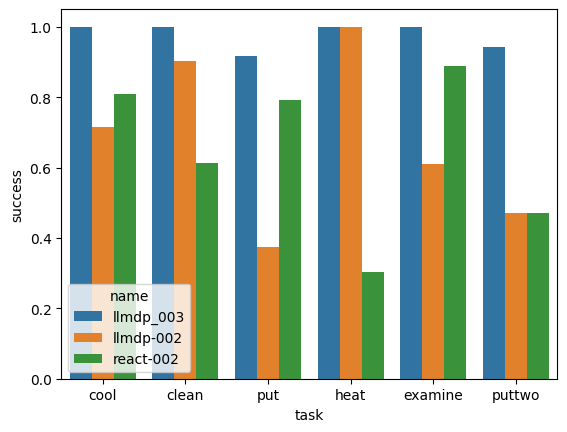

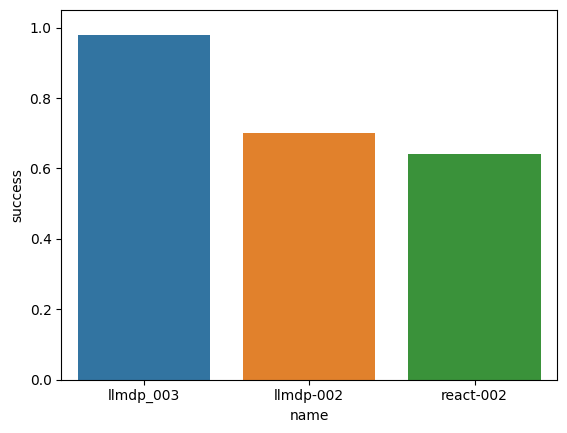

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(dataset)
df["success"] = df["success"].astype(int)
df["name"] = df["file"].apply(lambda x: file_to_name[x])


sns.barplot(x="task", y="success", hue="name",
              data=df, errwidth=0)
plt.show()

sns.barplot(y="success", x="name",
              data=df, errwidth=0)
plt.show()

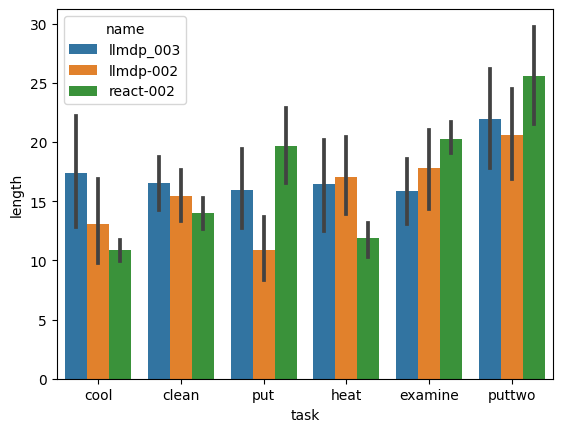

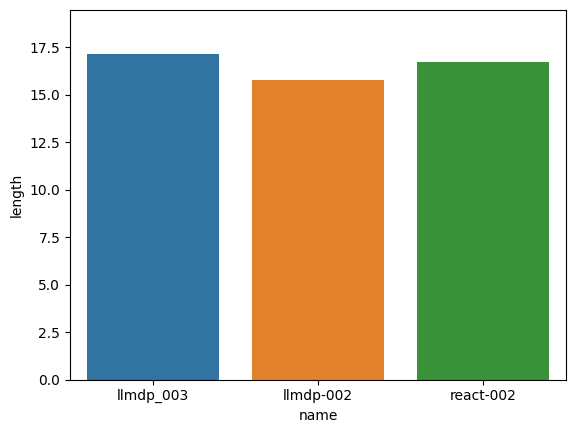

In [81]:
sns.barplot(x="task", y="length", hue="name", data=df[df.success == 1])
plt.show()

sns.barplot(y="length", x="name",
              data=df[df.success == 1], errwidth=0)
plt.show()

### Estimating Token Counts (cost)

In [83]:
import tiktoken
from collections import defaultdict

encoding = tiktoken.encoding_for_model("text-davinci-002")

min_token_count = defaultdict(int)
with open("prompts/alfworld_react.json", "r") as file:
    prompts = json.loads(file.read())
    for k, v in prompts.items():
       if k.startswith("react"):
          min_token_count[k.split("_")[1]] += len(encoding.encode(v))

print(min_token_count)

df.loc[df.name == "react-002", "llm_tokens"] = df[df.name == "react-002"].apply(lambda x: x["length"]*min_token_count[x["task"]], axis=1)

defaultdict(<class 'int'>, {'put': 934, 'clean': 1407, 'heat': 1122, 'cool': 1323, 'puttwo': 1333, 'examine': 1297})


In [84]:
df["llm_tokens"]

0        929.0
1        941.0
2        939.0
3        932.0
4        943.0
        ...   
397    28534.0
398    25940.0
399    54978.0
400    68943.0
401    63553.0
Name: llm_tokens, Length: 402, dtype: float64

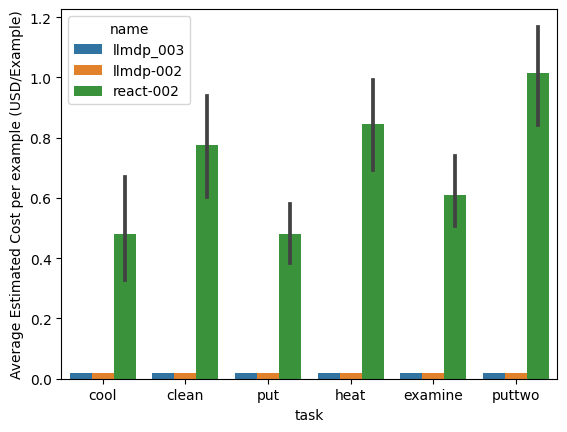

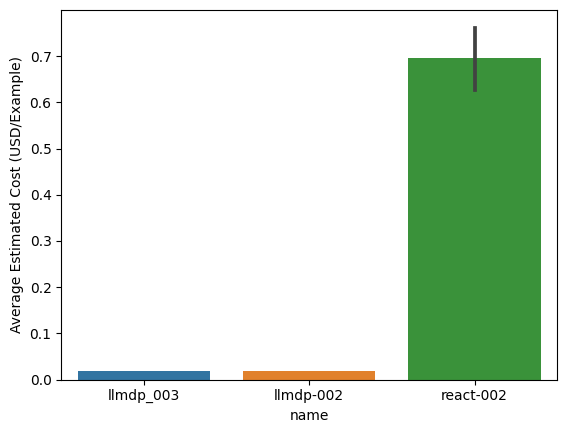

In [85]:
df["cost"] = df["llm_tokens"]*0.0200/1000

sns.barplot(x="task", y="cost", hue="name", data=df)
plt.ylabel("Average Estimated Cost per example (USD/Example)")
plt.show()

sns.barplot(y="cost", 
            x="name",
            data=df)
plt.ylabel("Average Estimated Cost (USD/Example)")
plt.show()

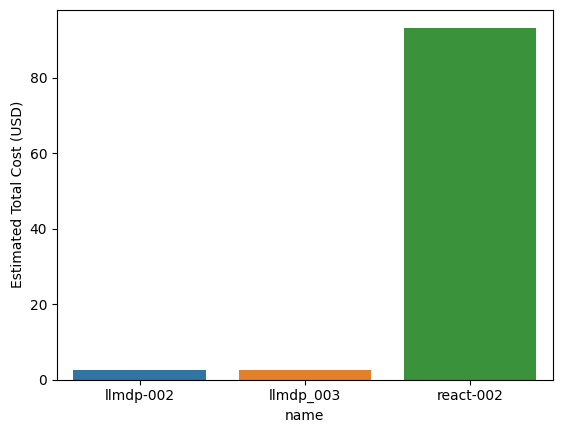

In [86]:
# aggregate cost per name and then plot
new_df = df.groupby("name").sum()["cost"]
new_df = new_df.reset_index()
sns.barplot(y="cost",
            x="name",
            data=new_df)
plt.ylabel("Estimated Total Cost (USD)")
plt.show()

In [78]:
# df